github url:  https://github.com/Bessonica/NNprojects

# The problem:
   * create GAN that generates dog images


# Data:
  * based on  Stanford Dogs Dataset.
  * 2 zip files
    * all-dogs.zip - All dog images 
    * Annotations.zip - Class labels, Bounding boxes
 
# Each sample of data consists of:
  * size 64x64px
 
# Columns:


# import

In [5]:
# need this to interact/open data
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from keras import layers
# from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt




import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# unzip and set up variables

In [6]:
import zipfile

with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/")
    
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/")
    

    #set up variables
SEED = 4250
np.random.seed(SEED)
random_dim = 128
ROOT = '/kaggle/working/'

# EDA 
 * Inspect
 * Visualize
 * Clean
 
 

# Data processing

* convert rgb value to range from 0 to 1 
* size 64x64 px.

Found 20579 files belonging to 1 classes.


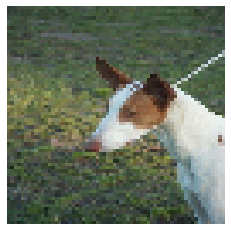

In [7]:
dataset = keras.preprocessing.image_dataset_from_directory(
    ROOT+"all-dogs/", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

#  GAN architecture

  * input layer 64x64x3

  * discriminator, generator and optimizer

  * Using leakyReLu and Dropout layers for better result and more controlled losses.

  * Activation function is sigmoid (we have only real and fake photos)

# Generator



In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0 

# Discriminator



In [9]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

<h2>loss function, train step</h2>

I got it from lectures web link (week 5)

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Inspect


monitor for our GAN.Save generated photo of dogs 

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/kaggle/working/res/generated_img_%03d_%d.png" % (epoch, i))

# Training
  * take small learning rate
  * Adam as optimizer function
  * loss function = binary crossentropy 

In [12]:
import time
epochs = 4
os.mkdir("/kaggle/working/res")

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

start = time.time()

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

print("--- %s seconds ---" % (time.time() - start))

Epoch 1/4
 24/644 [>.............................] - ETA: 1:18:41 - d_loss: 0.6685 - g_loss: 0.7934

KeyboardInterrupt: 

# Showcase (visualise) results

In [ ]:
import cv2
    
fig = plt.figure(figsize=(9, 15))

for i in range(5):
    for j in range(3):
        img = cv2.imread(ROOT+"res/generated_img_%03d_%d.png" % (i, j))
        fig.add_subplot(5, 3, i*3+j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %03d,photo #%d"%(i,j))

# What we have in the end

In [ ]:
fig = plt.figure(figsize=(9, 20))

for i in range(15):
    for j in range(3):
        img = cv2.imread(ROOT+"res/generated_img_%03d_%d.png" % (i*10, j))
        fig.add_subplot(15, 3, i*3+j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %03d,photo #%d"%(i*10+10,j))